# EmBDD: Embedding-based Drug Discovery

In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
import os
import sys
import json
import requests
from tqdm import tqdm
import utils

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
import pickle
import faiss

from upsetplot import plot, from_contents, UpSet
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from IPython.display import HTML, display, Markdown, IFrame, FileLink, Image, HTML

sys_path = "/home/songhyeon/Research/Embedding_appyter"
sys.path.append(sys_path)

In [3]:
%%appyter hide_code
{% do SectionField(
    name='LB_Section',
    title='Select a Library',
    subtitle='Option 1: Select your library: KCB(Korean Chemical Bank, 600K), ZINC(20K), MCE(1K), Selleckchem(2K). Option 2: Upload your custom library.',
    img='library.png'
) %}

%%appyter hide_code
{% do SectionField(
    name='Data_Section',
    title='Load your Data',
    subtitle='Load your data in tab separated formats without headers and index columns (One drug per row). Option 1: One prototype. Option 2: Multiple prototypes (maximum 10 prototypes).',
    img='data.png'
) %}

%%appyter hide_code
{% do SectionField(
    name='Parameter_Section',
    title='Set Parameters',
    subtitle='You can set options. Option 1: the maximum number(K) of top candidate. Option 2: You can choose gene expression-based or molecular structure-based embedding methods',
    img='setting.png'
) %}

```python
%%appyter hide_code
%%appyter hide_code
```

In [4]:
%%appyter hide_code_exec

{% set LB_field = TabField(
    name='lb_field',
    label='Library Selection',
    default='Select a Library',
    choices={
        'Select a Library': [
            ChoiceField(
                name='lb_kind',
                label='Select your library',
                default='Selleckchem',
                choices={'KCB':'kcb','ZINC':'zinc','MCE':'mce','Selleckchem':'selleck'}
            )
        ],
        'Custom Library': [
            FileField(
                name='custom',
                label='Load your Custom Library',
                description='Tab-delimeted file of your library. Columns should correspond to Drug2 Name, Drug2 SMILES without any headers and index columns')
        ]
    },
    section = 'LB_Section')
 %}

In [5]:
%%appyter hide_code_exec
{% set input_types = TabField(
    name='input_types',
    label='Data file',
    default='Multiple Prototypes and Candidates from Library',
    description='Upload your drugs information files',
    choices={        
        'One Prototype and Candiates from Library': [
            StringField(
                name='drug1_name', 
                label='Prototype Drug Name', 
                default='Palbociclib', 
                description='', 
                section='Data_Section'
            ),
            StringField(
                name='drug1_smiles', 
                label='Prototype Drug SMILES', 
                default='CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N3CCNCC3)N=C2N(C2CCCC2)C1=O', 
                description='', 
                section='Data_Section'
            )
        ],
        'Multiple Prototypes and Candidates from Library':[
            FileField(
                name='drug1_list_filename', 
                label='List of Candidates (.tsv or .txt)', 
                default='/home/songhyeon/Research/Embedding_appyter/drugs.txt',
                description='List of Candidates. Columns should correspond to Drug 1 Name and Drug 1 SMILES. One drug per row',
                section='Data_Section'
            )]

    },
    section = 'Data_Section',
) %}

In [6]:
%%appyter hide_code_exec
{% set topk_candidate = IntField(
    name='topk_candidate', 
    label='Top K Candidates', 
    min=1, 
    max=10000, 
    default=100, 
    description='The maximum number of Top candidates', 
    section='Parameter_Section')
%}

{% set embedding_method = ChoiceField(
    name='embedding_method',
    label='Embedding Methods',
    choices={'ReSimNet (Expression-based)':'resimnet','ECFP (Structure-based)':'ecfp','Mol2vec (Structure-based)':'mol2vec'},
    default='ReSimNet (Expression-based)',
    description='Select a embedding method',
    section='Parameter_Section')
%}

### Create Input/Output Path

In [7]:
%%appyter code_exec

input_path = './input_data/'
if not os.path.exists(input_path):
    os.makedirs(input_path)
    
output_path = './output_data/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

```python
input_path = './input_data/'
if not os.path.exists(input_path):
    os.makedirs(input_path)
output_path = './output_data/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
```

### Load Data

In [8]:
%%appyter code_exec

{% if LB_field.raw_value == "Select a Library" %}
input_db = "{{ LB_field.value[0] }}"

{% elif LB_field.raw_value == "Custom Library" %}
input_db = "custom"
input_db_df = pd.read_csv({{ LB_field.value[0] }}, sep='\t', usecols=['drug2_name', 'drug2_smiles'])
{% endif %}

{% if input_types.raw_value == "One Prototype and Candiates from Library" %}
drug1_name = {{ input_types.value[0] }}
drug1_smiles = {{ input_types.value[1] }}
input_mode = "single"

{% elif input_types.raw_value == "Multiple Prototypes and Candidates from Library" %}
prototypes_filename = {{ input_types.value[0] }}
input_mode = "multiple"
{% endif %}

embed_method = "{{embedding_method.value}}"
topk_candidate = {{topk_candidate.value}}
library_df = utils.npl(input_db)[0]
npl = utils.npl(input_db)[1]

```python
input_db = "selleck"
prototypes_filename = '/home/songhyeon/Research/Embedding_appyter/drugs.txt'
input_mode = "multiple"
embed_method = "resimnet"
topk_candidate = 100
library_df = utils.npl(input_db)[0]
npl = utils.npl(input_db)[1]
```

### Embedding methods

#### ReSimNet

In [9]:
if embed_method == "resimnet":
    if input_mode == "multiple":
        df = pd.read_csv(prototypes_filename, sep="\t", header=None)
        df.columns = ["drug1_name", "drug1_smiles"]

        drug_dict = dict(zip(df["drug1_name"], df["drug1_smiles"]))        
        for name, smiles in drug_dict.items():
            globals()[f'input_embed_{name}'] = {name:smiles}
            with open(input_path + f'input_{name}.pkl', "wb") as f:
                pickle.dump(globals()[f'input_embed_{name}'], f)
                            
            input_embed_filename = input_path + f"input_{name}.pkl"
            output_embed_filename = output_path + f"output_{name}_embeddings.pkl"
            resimnet_model_filename = "ReSimNet7.mdl"
            
            !python $sys_path/ReSimNet/main.py --save-embed True --embed-d 2 --drug-file $input_embed_filename --output-filename $output_embed_filename --checkpoint-dir $sys_path/ReSimNet/results/ --model-name $resimnet_model_filename --data-path $sys_path/ReSimNet/tasks/data/drug\(v0.6\).pkl
            embedding_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(output_embed_filename, f"Download ReSimNet {name} embedding vectors")
            display(HTML(embedding_html))
            
    else:
        df = pd.DataFrame([{'drug1_name':drug1_name, 'drug1_smiles':drug1_smiles}])
        
        # save drug info as "input_pairs.pkl" 
        input_embed_filename = input_path + "input_drug.pkl"

        drug_dict = dict(zip(df["drug1_name"], df["drug1_smiles"]))
        with open(input_embed_filename, "wb") as f:
            pickle.dump(drug_dict, f)
               
        output_embed_filename = output_path + "output_drug_embeddings.pkl"   
        resimnet_model_filename = "ReSimNet7.mdl"
        !python $sys_path/ReSimNet/main.py --save-embed True --embed-d 2 --drug-file $input_embed_filename --output-filename $output_embed_filename --checkpoint-dir $sys_path/ReSimNet/results/ --model-name $resimnet_model_filename --data-path $sys_path/ReSimNet/tasks/data/drug\(v0.6\).pkl
        embedding_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(output_embed_filename, "Download embedding vectors")
        display(HTML(embedding_html))

#### ECFP

In [10]:
def smiles_to_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.SanitizeMol(mol)
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, useChirality=True)  # 2 is the radius parameter for ECFP
    ar = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(ecfp, ar)
        
    return ar

In [11]:
if embed_method == "ecfp":
    mce_ecfp = []
    for smile in mce.smiles:
        ecfp = smiles_to_ecfp(smile)
        mce_ecfp.append(ecfp)

#### mol2vec

In [12]:
if embed_method == "mol2vec":
    # making mol2vec files
    if input_mode == "multiple":
        df = pd.read_csv(prototypes_filename, sep="\t", header=None)
        df.columns = ["drug1_name", "drug1_smiles"]
        drug_dict = dict(zip(df["drug1_name"], df["drug1_smiles"]))
        
        for name, smiles in drug_dict.items():
            globals()[f'input_{name}'] = {name: smiles}
            globals()[f'input_embed_{name}'] = [globals()[f'input_{name}']]
            
            input_embed_filename = input_path + f"input_{name}.sdf"
            output_embed_filename = output_path + f"output_{name}_embeddings.csv"
            
            mol2sdf(input_embed_filename)
            
            !mol2vec featurize -i $input_embed_filename -o $output_embed_filename -m /home/songhyeon/Research/mol2vec/examples/models/model_300dim.pkl --uncommon UNK -r 1
            embedding_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(output_embed_filename, f"Download {name} embedding vectors")
            display(HTML(embedding_html))

### DB

#### KCB

In [13]:
resimnet_model = "ReSimNet7"
# multiple prototypes
for name, smiles in drug_dict.items():
    data_filename = f"{name}_candidates.tsv"
    output_embed_filename = output_path + f"output_{name}_embeddings.pkl"
    # predict score
    if input_db == "kcb":
        # search ZINC15 embeddings using FAISS
        embedding_vectors_directory = sys_path + "/Library/resimnet_kcb/"
        embedding_vectors_filenames = os.listdir(embedding_vectors_directory)
        result_df_list = list()

        try:
            faiss_index
            del faiss_index
        except:
            pass

        for i in range(10):        
            if resimnet_model != "All" and str(i) not in resimnet_model:
                continue
                
            for embedding_file_index, embedding_vectors_filename in enumerate(tqdm(embedding_vectors_filenames)):            
                if f"_{i}" in embedding_vectors_filename: 
                    # load ZINC15 embedding vectors
                    with open(embedding_vectors_directory+embedding_vectors_filename, "rb") as f:
                        embedding_vectors_dict = pickle.load(f)
                        
                    # add embedding vectors to faiss
                    embedding_vectors_df = pd.DataFrame.from_dict(embedding_vectors_dict).T
                    embedding_vectors = np.ascontiguousarray(np.float32(embedding_vectors_df.values))
                        
                    faiss.normalize_L2(embedding_vectors)
                
                    try:
                        faiss_index
                    except:
                        faiss_index = faiss.IndexFlatIP(embedding_vectors.shape[1])
                        faiss_index = faiss.IndexIDMap2(faiss_index)
                        
                    faiss_index.add_with_ids(embedding_vectors, npl)
            
            print(f"{name}: Searching from {faiss_index.ntotal} candidates...")
                # load query embedding vector
            with open(output_embed_filename, "rb") as f:
                query_embedding_vectors = pickle.load(f)

            query_embedding_vectors = np.ascontiguousarray(np.float32(pd.DataFrame.from_dict(query_embedding_vectors).values)).T
            faiss.normalize_L2(query_embedding_vectors)

            Similarity, Index = faiss_index.search(query_embedding_vectors, topk_candidate)
            result_tmp_df = pd.DataFrame(index=["0094-22-"+str(x) for x in Index[0]])
            result_df_list.append(result_tmp_df)
            
        globals()[f'{name}_result_df'] = pd.concat(result_df_list, axis=1).reset_index()
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug2_name"})
        globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], kcb_df)
        globals()[f'{name}_result_df'].to_csv(data_filename, sep="\t")

#### ZINC

In [14]:
resimnet_model = "ReSimNet7"
# multiple prototypes
if embed_method == "resimnet":
    for name, smiles in drug_dict.items():
        data_filename = f"{name}_candidates.tsv"
        output_embed_filename = output_path + f"output_{name}_embeddings.pkl"
        # predict score
        if input_db == "zinc":
            # search ZINC15 embeddings using FAISS
            embedding_vectors_directory = sys_path + "/Library/resimnet_zinc/"
            embedding_vectors_filenames = os.listdir(embedding_vectors_directory)
            result_df_list = list()

            try:
                faiss_index
                del faiss_index
            except:
                pass

            for i in range(10):        
                if resimnet_model != "All" and str(i) not in resimnet_model:
                    continue
                    
                for embedding_file_index, embedding_vectors_filename in enumerate(tqdm(embedding_vectors_filenames)):            
                    if f"_{i}" in embedding_vectors_filename: 
                        # load ZINC15 embedding vectors
                        with open(embedding_vectors_directory+embedding_vectors_filename, "rb") as f:
                            embedding_vectors_dict = pickle.load(f)
                            
                        # add embedding vectors to faiss
                        embedding_vectors_df = pd.DataFrame.from_dict(embedding_vectors_dict).T
                        embedding_vectors = np.ascontiguousarray(np.float32(embedding_vectors_df.values))
                            
                        faiss.normalize_L2(embedding_vectors)
                    
                        try:
                            faiss_index
                        except:
                            faiss_index = faiss.IndexFlatIP(embedding_vectors.shape[1])
                            faiss_index = faiss.IndexIDMap2(faiss_index)
                            
                        faiss_index.add_with_ids(embedding_vectors, npl)

                print(f"{name}: Searching from {faiss_index.ntotal} candidates...")
                    # load query embedding vector
                with open(output_embed_filename, "rb") as f:
                    query_embedding_vectors = pickle.load(f)

                query_embedding_vectors = np.ascontiguousarray(np.float32(pd.DataFrame.from_dict(query_embedding_vectors).values)).T
                faiss.normalize_L2(query_embedding_vectors)

                Similarity, Index = faiss_index.search(query_embedding_vectors, topk_candidate)
                
                embedding_df = embedding_vectors_df.reset_index()
                embedding_df = embedding_df['index']
                emb_list = list(embedding_df[Index[0]])
                result_tmp_df = pd.DataFrame(index=[str(x) for x in emb_list])
                result_df_list.append(result_tmp_df)
                
            globals()[f'{name}_result_df'] = pd.concat(result_df_list, axis=1).reset_index()
            globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug2_name"})
            globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], zinc_df)
            globals()[f'{name}_result_df'].to_csv(data_filename, sep="\t")

In [15]:
if embed_method == "mol2vec":
    if input_db == "zinc":
    # multiple prototypes
        for name, smiles in drug_dict.items():
            data_filename = f"{name}_candidates.tsv"
            output_embed_filename = output_path + f"output_{name}_embeddings.csv"
            # predict score
            # search ZINC15 embeddings using FAISS
            embedding_vectors_directory = sys_path + "/Library/mol2vec_zinc/"
            embedding_vectors_filenames = os.listdir(embedding_vectors_directory)
            result_df_list = list()

            try:
                faiss_index
                del faiss_index
            except:
                pass
                    
            for embedding_file_index, embedding_vectors_filename in enumerate(tqdm(embedding_vectors_filenames)):            
                # load ZINC15 embedding vectors
                with open(embedding_vectors_directory + embedding_vectors_filename, "rb") as f:
                    embedding_vectors_df = pd.read_csv(f, index_col=0)
                            
                # add embedding vectors to faiss
                embedding_vectors = np.ascontiguousarray(np.float32(embedding_vectors_df.values))
                            
                faiss.normalize_L2(embedding_vectors)

                try:
                    faiss_index
                except:
                    faiss_index = faiss.IndexFlatIP(embedding_vectors.shape[1])
                    faiss_index = faiss.IndexIDMap2(faiss_index)
                faiss_index.add_with_ids(embedding_vectors, npl)                        

            print(f"{name}: Searching from {faiss_index.ntotal} candidates...")
            # load query embedding vector
            with open(output_embed_filename, "rb") as f:
                query_embedding_vectors = pd.read_csv(f, index_col=0)
                query_embedding_vectors.drop(labels='Smiles', axis=1, inplace=True)
                query_embedding_vectors.set_index('ID', inplace=True)
                
            query_embedding_vectors = np.ascontiguousarray(np.float32(query_embedding_vectors.values))
            faiss.normalize_L2(query_embedding_vectors)
            Similarity, Index = faiss_index.search(query_embedding_vectors, topk_candidate)
                
            embedding_df = embedding_vectors_df.reset_index()
            embedding_df = embedding_df['ID']
            emb_list = list(embedding_df[Index[0]])
            result_tmp_df = pd.DataFrame(index=[str(x) for x in emb_list])
            result_df_list.append(result_tmp_df)
            
            globals()[f'{name}_result_df'] = pd.concat(result_df_list, axis=1).reset_index()
            globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug2_name"})
            globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], zinc_df)
            globals()[f'{name}_result_df'].to_csv(data_filename, sep="\t")


#### MCE

In [16]:
resimnet_model = "ReSimNet7"
# multiple prototypes
for name, smiles in drug_dict.items():
    data_filename = f"{name}_candidates.tsv"
    output_embed_filename = output_path + f"output_{name}_embeddings.pkl"
    # predict score
    if input_db == "mce":
        # search ZINC15 embeddings using FAISS
        embedding_vectors_directory = sys_path + "/Library/resimnet_mce/"
        embedding_vectors_filenames = os.listdir(embedding_vectors_directory)
        result_df_list = list()

        try:
            faiss_index
            del faiss_index
        except:
            pass

        for i in range(10):        
            if resimnet_model != "All" and str(i) not in resimnet_model:
                continue
                
            for embedding_file_index, embedding_vectors_filename in enumerate(tqdm(embedding_vectors_filenames)):            
                if f"_{i}" in embedding_vectors_filename: 
                    # load ZINC15 embedding vectors
                    with open(embedding_vectors_directory+embedding_vectors_filename, "rb") as f:
                        embedding_vectors_dict = pickle.load(f)
                        
                    # add embedding vectors to faiss
                    embedding_vectors_df = pd.DataFrame.from_dict(embedding_vectors_dict).T
                    embedding_vectors = np.ascontiguousarray(np.float32(embedding_vectors_df.values))
                        
                    faiss.normalize_L2(embedding_vectors)
                
                    try:
                        faiss_index
                    except:
                        faiss_index = faiss.IndexFlatIP(embedding_vectors.shape[1])
                        faiss_index = faiss.IndexIDMap2(faiss_index)
                        
                    faiss_index.add_with_ids(embedding_vectors, npl)

            print(f"{name}: Searching from {faiss_index.ntotal} candidates...")
                # load query embedding vector
            with open(output_embed_filename, "rb") as f:
                query_embedding_vectors = pickle.load(f)

            query_embedding_vectors = np.ascontiguousarray(np.float32(pd.DataFrame.from_dict(query_embedding_vectors).values)).T
            faiss.normalize_L2(query_embedding_vectors)

            Similarity, Index = faiss_index.search(query_embedding_vectors, topk_candidate)
            
            embedding_df = embedding_vectors_df.reset_index()
            embedding_df = embedding_df['index']
            emb_list = list(embedding_df[Index[0]])
            result_tmp_df = pd.DataFrame(index=[str(x) for x in emb_list])
            result_df_list.append(result_tmp_df)
            
        globals()[f'{name}_result_df'] = pd.concat(result_df_list, axis=1).reset_index()
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug2_name"})
        globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], mce_df)
        globals()[f'{name}_result_df'].to_csv(data_filename, sep="\t")

In [35]:
print(os.getcwd())

/home/songhyeon/Research/Embedding_appyter


#### Selleckchem

In [38]:
resimnet_model = "ReSimNet7"
# multiple prototypes
for name, smiles in drug_dict.items():
    data_filename = f"{name}_candidates.tsv"
    output_embed_filename = output_path + f"output_{name}_embeddings.pkl"
    # predict score
    if input_db == "selleck":
        # search ZINC15 embeddings using FAISS
        embedding_vectors_directory = sys_path + "/Library/resimnet_selleck/"
        embedding_vectors_filenames = os.listdir(embedding_vectors_directory)
        result_df_list = list()

        try:
            faiss_index
            del faiss_index
        except:
            pass

        for i in range(10):        
            if resimnet_model != "All" and str(i) not in resimnet_model:
                continue
                
            for embedding_file_index, embedding_vectors_filename in enumerate(tqdm(embedding_vectors_filenames)):            
                if f"_{i}" in embedding_vectors_filename: 
                    # load ZINC15 embedding vectors
                    with open(embedding_vectors_directory+embedding_vectors_filename, "rb") as f:
                        embedding_vectors_dict = pickle.load(f)
                        
                    # add embedding vectors to faiss
                    embedding_vectors_df = pd.DataFrame.from_dict(embedding_vectors_dict).T
                    embedding_vectors = np.ascontiguousarray(np.float32(embedding_vectors_df.values))
                        
                    faiss.normalize_L2(embedding_vectors)
                
                    try:
                        faiss_index
                    except:
                        faiss_index = faiss.IndexFlatIP(embedding_vectors.shape[1])
                        faiss_index = faiss.IndexIDMap2(faiss_index)
                        
                    faiss_index.add_with_ids(embedding_vectors, npl)

            print(f"{name}: Searching from {faiss_index.ntotal} candidates...")
                # load query embedding vector
            with open(output_embed_filename, "rb") as f:
                query_embedding_vectors = pickle.load(f)

            query_embedding_vectors = np.ascontiguousarray(np.float32(pd.DataFrame.from_dict(query_embedding_vectors).values)).T
            faiss.normalize_L2(query_embedding_vectors)

            Similarity, Index = faiss_index.search(query_embedding_vectors, topk_candidate)
            
            embedding_df = embedding_vectors_df.reset_index()
            embedding_df = embedding_df['index']
            emb_list = list(embedding_df[Index[0]])
            result_tmp_df = pd.DataFrame(index=[str(x) for x in emb_list])
            result_df_list.append(result_tmp_df)
            
        globals()[f'{name}_result_df'] = pd.concat(result_df_list, axis=1).reset_index()
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug2_name"})
        globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], library_df)
        globals()[f'{name}_result_df'].to_csv(data_filename, sep="\t")

100%|██████████| 10/10 [00:00<00:00, 109.93it/s]


seliciclib: Searching from 3729 candidates...


100%|██████████| 10/10 [00:00<00:00, 106.73it/s]


Palbociclib: Searching from 3729 candidates...


100%|██████████| 10/10 [00:00<00:00, 108.03it/s]


indisulam: Searching from 3729 candidates...


100%|██████████| 10/10 [00:00<00:00, 102.79it/s]


Meloxicam: Searching from 3729 candidates...


#### Custom

#### Candidates Results

In [18]:
def make_clickable(smiles, site="pubchem"):
    if site == "pubchem":
        url = f"https://pubchem.ncbi.nlm.nih.gov/#query={smiles}&input_type=smiles"
    else:
        url = f"https://zinc15.docking.org/substances/{smiles}/" #smiles is actually ZINC15 ID
    return '<a href="{}" rel="noopener noreferrer" target="_blank">{}</a>'.format(url,smiles)

##### ReSimNet

In [19]:
# multiple prototypes
for name, smiles in drug_dict.items():
    globals()[f'{name}_df'] = pd.read_csv(f'{name}_candidates.tsv', sep="\t", index_col=0)
    globals()[f'{name}_df']["drug1_name"] = name
    globals()[f'{name}_df']["drug1_smiles"] = smiles
    
    input_filename = f"./input_pairs_{name}.tsv"
    output_filename = f"output_data/output_pairs_{name}.tsv"
    globals()[f'{name}_df'].to_csv(input_filename, index=None, sep="\t")
    
    # resimnet score calculation
    !python $sys_path/ReSimNet/main.py --save-prediction-new-pairs True --new-drug-pair-filename $input_filename --output-filename $output_filename --checkpoint-dir $sys_path/ReSimNet/results/ --data-path $sys_path/ReSimNet/tasks/data/drug\(v0.6\).pkl

In [20]:
for name, smiles in drug_dict.items():
    output_filename = output_path + f'output_pairs_{name}.tsv'
    globals()[f'{name}_result_df'] = pd.read_csv(output_filename, sep="\t")
    globals()[f'{name}_result_df']['drug2_smiles'] = globals()[f'{name}_result_df'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
    globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].set_index(['drug2_name', 'drug2_smiles'])
    globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].drop(['drug1_name','drug1_smiles'], axis=1)
    globals()[f'{name}_result_df']["ReSimNet_avg"] = globals()[f'{name}_result_df'][[x for x in globals()[f'{name}_result_df'].columns if x.startswith("ReSimNet")]].mean(axis=1)
    globals()[f'{name}_result_df']['ReSimNet_std'] = globals()[f'{name}_result_df'][[x for x in globals()[f'{name}_result_df'].columns if x.startswith('ReSimNet')]].std(axis=1)
    # order columns
    globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].reindex(sorted(globals()[f'{name}_result_df'].columns), axis=1)
    globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].sort_values(["ReSimNet_avg", "jaccard_similarity"], ascending=False)
    globals()[f'{name}_result_df'].reset_index(drop=False, inplace=True)
    # rank
    globals()[f'{name}_result_df']['rank'] = [x for x in range(1,topk_candidate+1)]
    globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].set_index(['rank'])
    globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'][globals()[f'{name}_result_df']['ReSimNet_avg']>0.90]
    globals()[f'{name}_result_df'].rename(columns={'drug2_name':'compound_name'}, inplace=True)
    
    # html
    globals()[f'{name}_result_df1'] = pd.read_csv(output_filename, sep="\t")
    globals()[f'{name}_result_df1']['drug2_smiles'] = globals()[f'{name}_result_df1'].apply(lambda x: make_clickable(x['drug2_smiles']), axis=1)
    globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].set_index(['drug2_name', 'drug2_smiles'])
    globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].drop(['drug1_name','drug1_smiles'], axis=1)
    globals()[f'{name}_result_df1']["ReSimNet_avg"] = globals()[f'{name}_result_df1'][[x for x in globals()[f'{name}_result_df1'].columns if x.startswith("ReSimNet")]].mean(axis=1)
    globals()[f'{name}_result_df1']['ReSimNet_std'] = globals()[f'{name}_result_df1'][[x for x in globals()[f'{name}_result_df1'].columns if x.startswith('ReSimNet')]].std(axis=1)
    # order columns
    globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].reindex(sorted(globals()[f'{name}_result_df1'].columns), axis=1)
    globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].sort_values(["ReSimNet_avg", "jaccard_similarity"], ascending=False)
    globals()[f'{name}_result_df1'].reset_index(drop=False, inplace=True)
    # rank
    globals()[f'{name}_result_df1']['rank'] = [x for x in range(1,topk_candidate+1)]
    globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].set_index(['rank'])
    globals()[f'{name}_result_df1'].drop(columns=['ReSimNet_0','ReSimNet_1','ReSimNet_2','ReSimNet_3','ReSimNet_4','ReSimNet_5','ReSimNet_6','ReSimNet_7','ReSimNet_8','ReSimNet_9'], inplace=True)
    globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'][globals()[f'{name}_result_df1']['ReSimNet_avg']>0.90]
    globals()[f'{name}_result_df1'].rename(columns={'drug2_name':'compound_name'}, inplace=True)

In [21]:
css = """
<style>
table.dataframe td{
    white-space: pre-wrap;
    max-width: 450px;
    overflow: hidden;
}
</style>
"""
i = 1
for name in drug_dict.keys():
    print(f"Table {i}. Top {topk_candidate} compounds similar to {name} based on {embed_method} embedding")
    globals()[f'{name}_result_df'].to_csv(f'{name}_results.tsv',sep='\t')
    globals()[f'{name}_html'] = "<a href=\"./{}\" target='_blank'>{}</a>".format(f'{name}_results.tsv', "Download results: {}".format(f'{name}_results.tsv'))
    i+=1
    display(HTML(css + globals()[f'{name}_result_df1'].to_html(render_links=True, escape=False)))
    display(HTML(globals()[f'{name}_html']))

Table 1. Top 100 compounds similar to seliciclib based on resimnet embedding


,compound_name,drug2_smiles,ReSimNet_avg,ReSimNet_std,jaccard_similarity
rank,,,,,
1,"Roscovitine (Seliciclib,CYC202)",CCC(CO)NC1=NC(=C2N=C[N](C(C)C)C2=N1)NCC3=CC=CC=C3,0.979280,0.009440,0.818182
2,Bohemine,CC(C)[N]1C=NC2=C1N=C(NCCCO)N=C2NCC3=CC=CC=C3,0.966453,0.010858,0.689655
3,BIO,O\N=C/1\C(NC2=CC=CC=C12)=C3\C(=O)NC4=C3C=CC(=C4)Br,0.960606,0.017540,0.072289
4,StemRegenin 1 (SR1),CC(C)[N]1C=NC2=C1N=C(N=C2NCCC3=CC=C(O)C=C3)C4=CSC5=CC=CC=C45,0.953601,0.015800,0.384615
5,BIO-acetoxime,CC(=O)O\N=C/1\C(NC2=CC=CC=C12)=C3\C(=O)NC4=C3C=CC(=C4)Br,0.952889,0.024106,0.078652
6,Mycophenolate Mofetil,COC1=C(C)C2=C(C(=O)OC2)C(=C1C\C=C(C)\CCC(=O)OCCN3CCOCC3)O,0.952336,0.021505,0.057692
7,PRT4165,O=C1C2=C(C=CC=C2)C(=O)C1=CC3=CC=CN=C3,0.945194,0.027565,0.114286
8,A-83-01,CC1=CC=CC(=N1)C2=N[N](C=C2C3=CC=NC4=CC=CC=C34)C(=S)NC5=CC=CC=C5,0.944513,0.017721,0.146067
9,AS1517499,NC(=O)C1=CN=C(NCCC2=CC=C(O)C(=C2)Cl)N=C1NCC3=CC=CC=C3,0.941393,0.029177,0.291139


Table 2. Top 100 compounds similar to Palbociclib based on resimnet embedding


,compound_name,drug2_smiles,ReSimNet_avg,ReSimNet_std,jaccard_similarity
rank,,,,,
1,Palbociclib (PD-0332991) HCl,Cl.CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O,0.999454,0.000257,0.984127
2,Palbociclib (PD0332991) Isethionate,CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O.OCC[S](O)(=O)=O,0.992479,0.003776,0.849315
3,BSJ-03-123,CC(=O)C1=C(C)C2=CN=C(NC3=CC=C(C=N3)N4CCN(CCOCCOCCOCCNC(=O)COC5=CC=CC6=C5C(=O)N(C7CCC(=O)NC7=O)C6=O)CC4)N=C2N(C8CCCC8)C1=O,0.970692,0.005891,0.527778
4,Ribociclib (LEE011),CN(C)C(=O)C1=CC2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2[N]1C5CCCC5,0.966531,0.010587,0.605263
5,LY2119620,CN1CCN(CC1)C(=O)COC2=C(Cl)C(=C3C(=C(SC3=N2)C(=O)NC4CC4)N)C,0.961791,0.013410,0.166667
6,JQ-EZ-05 (JQEZ5),CCCC1=C(CNC(=O)C2=CC(=NC3=C2C=N[N]3C(C)C)C4=CC=C(N=C4)N5CCN(C)CC5)C(=O)NC(=C1)C,0.961065,0.013019,0.192982
7,FF-10101,CCCNC1=NC(=NC=C1C#CCCCNC(=O)C(C)N(C)C(=O)\C=C\CN(C)C)NC2=CC=C(C=C2)C#N,0.956556,0.007688,0.142857
8,INCB024360 analogue,NC1=NON=C1C(/NC2=CC=C(F)C(=C2)Cl)=N\O,0.952413,0.017206,0.062500
9,Sulfatinib,CN(C)CCN[S](=O)(=O)CC1=CC(=CC=C1)NC2=NC=CC(=N2)OC3=CC4=C([NH]C(=C4)C)C=C3,0.952179,0.017430,0.127273


Table 3. Top 100 compounds similar to indisulam based on resimnet embedding


,compound_name,drug2_smiles,ReSimNet_avg,ReSimNet_std,jaccard_similarity
rank,,,,,
1,Eltanexor (KPT-8602),NC(=O)/C(=C/[N]1C=NC(=N1)C2=CC(=CC(=C2)C(F)(F)F)C(F)(F)F)C3=CN=CN=C3,0.938985,0.041624,0.051282
2,SR1001,CC(=O)NC1=NC(=C(S1)[S](=O)(=O)NC2=CC=C(C=C2)C(O)(C(F)(F)F)C(F)(F)F)C,0.933219,0.027977,0.121622
3,Kevetrin hydrochloride,Cl.NC(=N)SCCCC#N,0.932512,0.027999,0.016949
4,ESI-09,CC(C)(C)C1=CC(=NO1)C(=O)/C(=N/NC2=CC=CC(=C2)Cl)C#N,0.932272,0.029126,0.133333
5,IDO-IN-1,NC1=NON=C1C(NO)=NC2=CC=C(F)C(=C2)Br,0.931730,0.039721,0.085714
6,Benzethonium Chloride,[Cl-].CC(C)(C)CC(C)(C)C1=CC=C(OCCOCC[N+](C)(C)CC2=CC=CC=C2)C=C1,0.931176,0.022864,0.095890
7,Raphin1,NC(=N)N\N=C\C1=C(Cl)C(=CC=C1)Cl,0.928983,0.037542,0.172414
8,Sulfameter,COC1=CN=C(N[S](=O)(=O)C2=CC=C(N)C=C2)N=C1,0.926861,0.046595,0.250000
9,Pilocarpine HCl,Cl.CCC1C(COC1=O)CC2=CN=C[N]2C,0.919338,0.034201,0.042254


Table 4. Top 100 compounds similar to Meloxicam based on resimnet embedding


,compound_name,drug2_smiles,ReSimNet_avg,ReSimNet_std,jaccard_similarity
rank,,,,,
1,Meloxicam,CN1C(=C(O)C2=C(C=CC=C2)[S]1(=O)=O)C(=O)NC3=NC=C(C)S3,1.000000,2.939388e-08,1.000000
2,Mosapride,CCOC1=CC(=C(Cl)C=C1C(=O)NCC2CN(CCO2)CC3=CC=C(F)C=C3)N,0.956325,1.470676e-02,0.114583
3,Palbociclib (PD0332991) Isethionate,CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O.OCC[S](O)(=O)=O,0.924475,3.351894e-02,0.122642
4,Palbociclib (PD-0332991) HCl,Cl.CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O,0.923698,3.162167e-02,0.135417
5,Erlotinib,COCCOC1=C(OCCOC)C=C2C(=NC=NC2=C1)NC3=CC=CC(=C3)C#C,0.906052,4.162238e-02,0.107143
6,LY2608204,O=C(NC1=NC=C(SCCN2CCCC2)S1)C3(CC3C4CCCCC4)C5=CC=C(C=C5)[S](=O)(=O)C6CC6,0.905412,3.954366e-02,0.191489
7,NVP 231,O=C(NC1=NC2=C(S1)C=C(NC(=O)[C]34C[CH]5C[CH]([CH2]C([CH2]5)C3)C4)C=C2)C6=CC=CC=C6,0.905036,3.948877e-02,0.217949
8,Erlotinib HCl (OSI-744),Cl.COCCOC1=C(OCCOC)C=C2C(=NC=NC2=C1)NC3=CC=CC(=C3)C#C,0.904359,4.160145e-02,0.105882
9,MC1568,C[N]1C=C(/C=C/C(=O)C2=CC=CC(=C2)F)C=C1\C=C\C(=O)NO,0.902609,3.624870e-02,0.137500


### Plots

##### Upset plots (candidates intersection btw multiple prototypes)

You can see if there are overlapping compounds in the results of each prototype. 
It can help you decide which compound to prioritize among the numerous results.


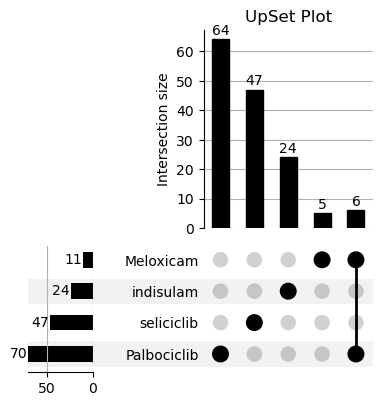

In [22]:
if input_mode == "multiple":
    upset_dict = {}

    for name in drug_dict.keys():
        upset_dict[f"{name}"] = list(globals()[f'{name}_result_df1']['compound_name'])

    upsetplot = from_contents(upset_dict)
    
    UpSet(upsetplot, subset_size='count', show_counts=True).plot()
    plt.title('UpSet Plot')
    plt.savefig('Upset_plot.png')
    display(HTML(f'<a href="./Upset_plot.png" download>Download: UpSet Plot</a>'))
    print("You can see if there are overlapping compounds in the results of each prototype. \nIt can help you decide which compound to prioritize among the numerous results.")


##### Drug Enrichr

In [23]:
for drug, candidates in upset_dict.items():
    def drug_enrichr_link(dataset, title = "Drug Enrichr Overall Results: {}"):
        url = f"https://maayanlab.cloud/DrugEnrichr/enrich?dataset={dataset}"
        html = "<a href=\"{}\" target='_blank'>{}</a>".format(url, title.format(drug))
        return HTML(html)

    ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/addList'
    drugs_str = '\n'.join(candidates)
    description = f'{drug} candidates'
    payload = {
        'list': (None, drugs_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing drug list')

    data = json.loads(response.text)

    ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/view?userListId=%s'
    user_list_id = data['userListId']
    dataset = data['shortId']
    response = requests.get(ENRICHR_URL % user_list_id)
    if not response.ok:
        raise Exception('Error getting drug list')
        
    data = json.loads(response.text)
    
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    drug_set_library = 'Drug_Repurposing_Hub_Mechanism_of_Action'
    response = requests.get(
        ENRICHR_URL + query_string % (user_list_id, drug_set_library)
    )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text)
    moa = [item[1] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]
    p_value = [item[2] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]
    z_score = [item[3] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]
    comb_score = [item[4] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]

    df = pd.DataFrame({'moa': moa, 'p-value': p_value, 'z-score': z_score, 'combined score': comb_score})
    print(f"Table. Drug Enrichr MoA results of {drug}")
    display(df)
    display(drug_enrichr_link(dataset))

Table. Drug Enrichr MoA results of seliciclib


,moa,p-value,z-score,combined score
0,CDK inhibitor,0.036958,-120.652677,397.908862
1,retinoid receptor agonist,0.000293,-7.084259,57.625529
2,topoisomerase inhibitor,0.002724,-3.828669,22.610106


Table. Drug Enrichr MoA results of Palbociclib


,moa,p-value,z-score,combined score
0,ribonucleotide reductase inhibitor,0.037843,-9.307308,30.475111
1,retinoid receptor agonist,0.037843,-6.940226,22.724524
2,EGFR inhibitor,0.090379,-8.008593,19.250585
3,coagulation factor inhibitor,0.017380,-4.357697,17.659373
4,VEGFR inhibitor,0.096744,-7.183870,16.779261
5,apoptosis stimulant,0.020820,-2.333446,9.034769


Table. Drug Enrichr MoA results of indisulam


,moa,p-value,z-score,combined score
0,dihydrofolate reductase inhibitor,0.011938,-48.146837,213.195257
1,leukotriene receptor antagonist,0.007179,-8.133956,40.153672


Table. Drug Enrichr MoA results of Meloxicam


,moa,p-value,z-score,combined score
0,EGFR inhibitor,0.014754,-8.427589,35.532843
1,serotonin receptor agonist,0.014754,-5.771712,24.334997


##### Heatmap

In [26]:
if input_mode == "multiple":
    df = pd.read_csv(prototypes_filename, sep="\t", header=None)
    df.columns = ["drug2_name", "drug2_smiles"]

    drug_dict = dict(zip(df["drug2_name"], df["drug2_smiles"]))        
    for name, smiles in drug_dict.items():
        globals()[f'input_{name}_df'] = df
        globals()[f'input_{name}_df']['drug1_name'] = name
        globals()[f'input_{name}_df']['drug1_smiles'] = smiles
        
        input_filename = f"./input_heatmap_{name}.tsv"
        output_filename = f"./output_heatmap_{name}.tsv"
        globals()[f'input_{name}_df'].to_csv(input_filename, index=None, sep="\t")
        
        !python $sys_path/ReSimNet/main.py --save-prediction-new-pairs True --new-drug-pair-filename $input_filename --output-filename $output_filename --checkpoint-dir $sys_path/ReSimNet/results/ --data-path $sys_path/ReSimNet/tasks/data/drug\(v0.6\).pkl

In [27]:
data_avg = []
data_jac = []

for name in drug_dict.keys():
    output_filename = f'./output_heatmap_{name}.tsv'
    
    globals()[f'{name}_result_hp'] = pd.read_csv(output_filename, sep="\t")
    globals()[f'{name}_result_hp']['drug2_smiles'] = globals()[f'{name}_result_hp'].apply(lambda x: make_clickable(x['drug2_smiles']), axis=1)
    globals()[f'{name}_result_hp']["ReSimNet_avg"] = globals()[f'{name}_result_hp'][[x for x in globals()[f'{name}_result_hp'].columns if x.startswith("ReSimNet")]].mean(axis=1)
    globals()[f'{name}_result_hp_avg'] = globals()[f'{name}_result_hp'][['drug1_name','drug2_name','ReSimNet_avg']]
    globals()[f'{name}_result_hp_jac'] = globals()[f'{name}_result_hp'][['drug1_name','drug2_name','jaccard_similarity']]
    globals()[f'{name}_result_hp_avg_pv'] = globals()[f'{name}_result_hp_avg'].pivot(index='drug1_name', columns='drug2_name', values='ReSimNet_avg')
    globals()[f'{name}_result_hp_jac_pv'] = globals()[f'{name}_result_hp_jac'].pivot(index='drug1_name', columns='drug2_name', values='jaccard_similarity')
    
    data_avg.append(globals()[f'{name}_result_hp_avg_pv'])
    data_jac.append(globals()[f'{name}_result_hp_jac_pv'])
    heatmap_avg = pd.concat(data_avg, axis=0)
    heatmap_jac = pd.concat(data_jac, axis=0)

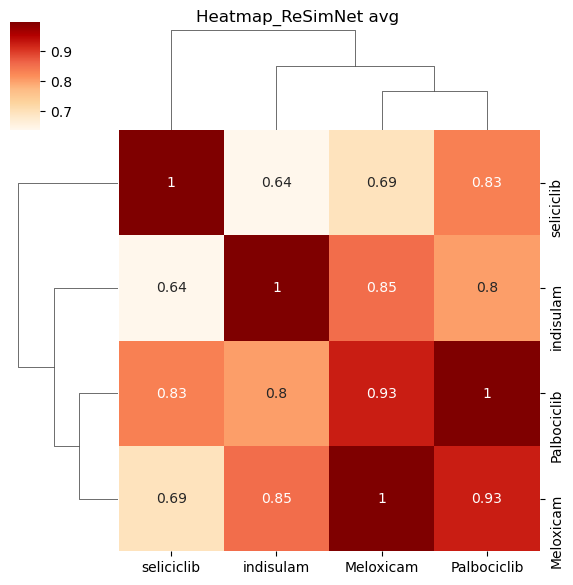

In [28]:
resavg = sns.clustermap(heatmap_avg, annot=True, cmap='OrRd', figsize=(6,6))
resavg.ax_heatmap.set_xlabel('')
resavg.ax_heatmap.set_ylabel('')
resavg.fig.suptitle('Heatmap_ReSimNet avg', y=1, x=0.5);
plt.savefig('heatmap_resimnet_avg.png')
display(HTML(f'<a href="./heatmap_resimnet_avg.png" download>Download: Heatmap_ReSimNet avg</a>'))

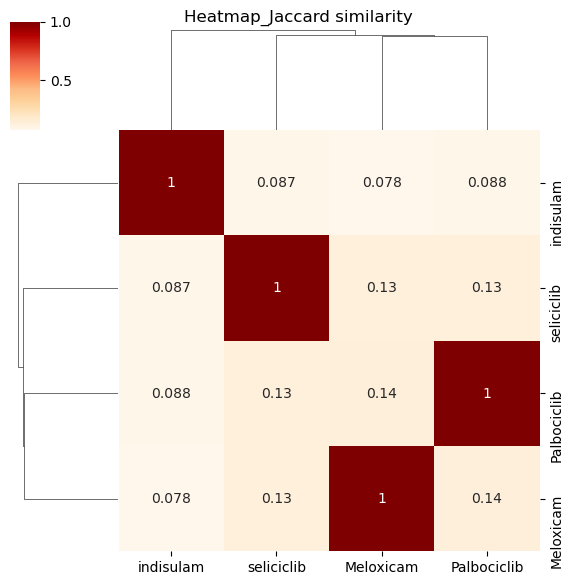

In [29]:
resjac = sns.clustermap(heatmap_jac, annot=True, cmap='OrRd', figsize=(6,6))
resjac.ax_heatmap.set_xlabel('')
resjac.ax_heatmap.set_ylabel('')
resjac.fig.suptitle('Heatmap_Jaccard similarity', y=1, x=0.5);
plt.savefig('heatmap_jaccard_similarity.png')
display(HTML(f'<a href="./heatmap_jaccard_similarity.png" download>Download: Heatmap_Jaccard similarity</a>'))